In [61]:
import importlib
importlib.reload(training_data)
from src.data.training_data import divide_gedi_data_into_a_grid, spatial_split_train_and_test_data
from src.data import shape_processor
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data import gedi_pipeline
import seaborn as sns
importlib.reload(gedi_pipeline)

2023-05-29 12:34:19,424 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.gedi_pipeline' from '/home/jk871/fire-regen/src/data/gedi_pipeline.py'>

### Get raw data

In [3]:
sierras = gpd.read_file("../../data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras)

In [4]:
# Get GEDI data - for each year, then combine.
print('Load 2019')
gedi_2019 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2019_may_28.csv", index_col=0)
print('Load 2020')
gedi_2020 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2020_may_28.csv", index_col=0)
print('Load 2021')
gedi_2021 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2021_may_28.csv", index_col=0)
print('Load 2022')
gedi_2022 = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_2022_may_28.csv", index_col=0)

print('Combine all years')
gedi = pd.concat([gedi_2019, gedi_2020, gedi_2021, gedi_2022])

Load 2019
Load 2020
Load 2021
Load 2022
Combine all years


In [5]:
gedi_gridded = divide_gedi_data_into_a_grid(4000, sierras_box, gedi)

-122.24772734966812
0.036098286589025634 0.03609404385148548
125.0 192.0


In [27]:
grouped_xy = gedi_gridded.groupby(['x', 'y']).count().reset_index()[['x', 'y', 'agbd']].rename(columns={'agbd':'shot_count'})

In [25]:
grouped_xy

,x,y,count
0,0.0,33.0,3
1,0.0,34.0,171
2,0.0,35.0,551
3,0.0,36.0,371
4,0.0,37.0,684
...,...,...,...
11546,124.0,156.0,647
11547,124.0,157.0,444
11548,124.0,158.0,176
11549,124.0,159.0,102


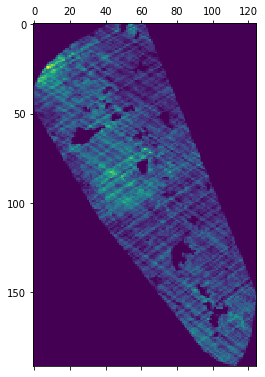

In [54]:
def plot_grid(df):
    df_grouped = df.groupby(['x', 'y']).count().reset_index()[['x', 'y', 'agbd']].rename(columns={'agbd':'shot_count'})
    nrows = 192
    ncols = 125

    image = np.zeros(nrows*ncols)
    image = image.reshape((nrows, ncols))

    for row_idx in range(df_grouped.shape[0]):
        row = df_grouped.iloc[row_idx]
        image[int(row.y), int(row.x)] = int(row.shot_count)

    plt.matshow(image)
    plt.show()
    
plot_grid(gedi_gridded)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xy_numpy, xy_numpy, test_size=0.15, random_state=0)

In [38]:
X_test[:, 2].sum() / X_train[:, 2].sum() 

0.17674067832468832

In [48]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['x', 'y', 'count']
X_test_df = X_test_df.drop(columns='count')
gedi_test = X_test_df.merge(right=gedi_gridded, on = ['x', 'y'], how='left')

In [49]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = ['x', 'y', 'count']
X_train_df = X_train_df.drop(columns='count')
gedi_train = X_train_df.merge(right=gedi_gridded, on = ['x', 'y'], how='left')

In [50]:
print(f'Total number of GEDI shots: {gedi_gridded.shape[0]}')
print(f'Test number of GEDI shots: {gedi_test.shape[0]}')
print(f'Training number of GEDI shots: {gedi_train.shape[0]}')
gedi_test.shape[0] + gedi_train.shape[0]

Total number of GEDI shots: 9032765
Test number of GEDI shots: 1356677
Training number of GEDI shots: 7676088


9032765

In [60]:
print('GEDI shots stats')
gedi_pipeline.get_burn_stats(gedi)
print('\n')

print('Test GEDI shots stats')
gedi_pipeline.get_burn_stats(gedi_test)
print('\n')

print('Training GEDI shots stats')
gedi_pipeline.get_burn_stats(gedi_train)
print('\n')

GEDI shots stats
Unburned ratio: 88.42640099681547%
High-burned ratio: 2.1629146778422776%
Medium-burned ratio: 3.1569956707608355%
Low-burned ratio: 4.488968770913447%


Test GEDI shots stats
Unburned ratio: 88.7314371806996%
High-burned ratio: 1.990009412704719%
Medium-burned ratio: 3.121597845323537%
Low-burned ratio: 4.426698469864235%


Training GEDI shots stats
Unburned ratio: 88.37248869476223%
High-burned ratio: 2.1934740716885996%
Medium-burned ratio: 3.163251906439843%
Low-burned ratio: 4.499974466160367%




In [52]:
# Save datasets
print('Save test GEDI shots')
gedi_test.to_csv(f"/maps/fire-regen/data/rf/gedi_test.csv")
print('Save train GEDI shots')
gedi_train.to_csv(f"/maps/fire-regen/data/rf/gedi_train.csv")

Save test GEDI shots
Save train GEDI shots


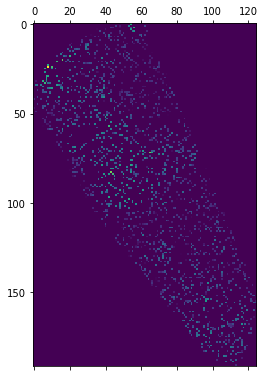

In [56]:
plot_grid(gedi_test)

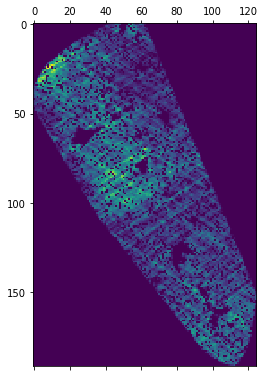

In [57]:
plot_grid(gedi_train)